# LSTM Monthly Temperature Prediction Example

Most of the time, the weather of one city is heavily related to its weather in the past. In fact, the weather should follow some seasonal patterns. Hence, in this example, we use Long-Short-Term-Memory Neural Network (LSTM) to find this hidden seasonal pattern in the temperature, and then make some sensible predictions for the future.

Reference:
- [Time Series Prediction with LSTM](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python)
- [Weather Forecasting with RNN](https://medium.com/analytics-vidhya/weather-forecasting-with-recurrent-neural-networks-1eaa057d70c3)
- [PyTorch LSTM Manual](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)


Import related libraries:

In [12]:
'''Train with PyTorch.'''
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch.utils.data as data

# SciKit
from sklearn.preprocessing import MinMaxScaler

# Python
import pandas as pd
import numpy as np
import os
import time

Declaring machine learning parameters:

In [13]:
# ML Parameters
lr = 1e-3
epoch = 500
batch_size = 20

# Input Dataset
input_datase_file = './surface-air-temperature-monthly-mean.csv'

# Normalization
scaler = MinMaxScaler(feature_range=(-1, 1))


Check if Pandas can read the dataset correctly:

In [14]:
# Load Dataset
df = pd.read_csv(input_datase_file, names = ["month", "mean_temp"], header=0) # read 2 columns
df.head()


,month,mean_temp
0,1982-01,25.9
1,1982-02,27.1
2,1982-03,27.2
3,1982-04,27.0
4,1982-05,28.0


Take 70% of data as training set, and 30% of data as validation set:

Make it as PyTorch Dataset Class. This class assumes the data is previous X month temperature, and the target is the 6th month temperature:

[t1 t2 t3 t4 t5 ... tX] --> [tX+1]

[t2 t3 t4 t5 t6 ... tX+1] --> [tX+2]

...

[tn-5 tn-4 tn-3 tn-2 tn-1 ... tX+1-n] --> [tn]


In [15]:
class TemperatureDataset(data.Dataset):

    def __init__(self):
        
        # read CSV
        self.df = pd.read_csv(input_datase_file, names = ["month", "mean_temp"], header=0) # read 2 columns
        self.orig_dataset = df.mean_temp.to_numpy()
        
        # store another normalized dataset
        self.normalized_dataset = np.copy(self.orig_dataset)
        self.normalized_dataset = self.normalized_dataset.reshape(-1, 1)

        # calculate normalization
        self.normalized_dataset = scaler.fit_transform(self.normalized_dataset)
        self.normalized_dataset = self.normalized_dataset.reshape(-1)
        
        # use X history data generate one target 
        self.sample_len = 18

    def __len__(self):
        
        if len(self.orig_dataset) > self.sample_len:
            return len(self.orig_dataset) - self.sample_len
        else:
            return 0

    def __getitem__(self, idx):
        
        # target is the last records
        target = self.normalized_dataset[self.sample_len+idx]
        target = np.array(target).astype(np.float64)  # convert to numpy array
        
        # data is the previous five records
        i = self.normalized_dataset[idx:(idx+self.sample_len)]

        # LSTM requires time-series data to shape in this way
        i = i.reshape((-1, 1))
        
        # convert to PyTorch tensors
        i = torch.from_numpy(i)
        target = torch.from_numpy(target)
        
        return i, target


Preparation of traning and validation set:

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load dataset
dataset = TemperatureDataset()

# Split training and validation set
train_len = int(0.7*len(dataset))
valid_len = len(dataset) - train_len
TrainData, ValidationData = random_split(dataset,[train_len, valid_len])

# Load into Iterator (each time get one batch)
train_loader = data.DataLoader(TrainData, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = data.DataLoader(ValidationData, batch_size=batch_size, shuffle=True, num_workers=0)

# Print statistics
print("Total: ", len(dataset))
print("Training Set: ", len(TrainData))
print("Validation Set: ", len(ValidationData))


Total:  448
Training Set:  313
Validation Set:  135


Our Machine Learning model is a Fully-Connected LSTM:

In [17]:
class TempLSTM(nn.Module):

    def __init__(self):

        # Required in PyTorch Model
        super(TempLSTM, self).__init__()
        
        # Parameters
        self.feature_dim = 1
        self.hidden_dim = 500
        self.num_layers = 3
        self.output_dim = 1

        # Neural Networks
        self.lstm = nn.LSTM(self.feature_dim, self.hidden_dim, self.num_layers, dropout=0.1, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim , self.output_dim)
        
    def forward(self, i):
        
        # From (batch, seq_len, input_size) to (seq_len, batch, input_size)
        #i = i.view(-1, i.shape[0], self.feature_dim)

        # Set initial hidden and cell states
        h0 = torch.zeros([self.num_layers, i.shape[0], self.hidden_dim], dtype=torch.double) #.requires_grad_()
        c0 = torch.zeros([self.num_layers, i.shape[0], self.hidden_dim], dtype=torch.double) #.requires_grad_()
        #h0 = torch.zeros([self.num_layers, i.shape[1], self.hidden_dim], dtype=torch.double) #.requires_grad_()
        #c0 = torch.zeros([self.num_layers, i.shape[1], self.hidden_dim], dtype=torch.double) #.requires_grad_()

        # Forward propagate LSTM
        out, _ = self.lstm.forward(i, (h0.detach(), c0.detach()))  # output shape (batch, sequence, hidden_dim)
        out = self.fc(out[:, -1, :])    # consume the last LSTM output in a time series
        #out, _ = self.lstm.forward(i, (h0.detach(), c0.detach()))  # output shape(seq_len, batch, hidden_size)
        #out = self.fc(out[-1, :, :])    # consume the last LSTM output in a time series
        return out


Define and build machine learning model:

In [18]:
# Define model
model = TempLSTM()
model = model.double()
print(model)

# Load into GPU if necessary
model = model.to(device)

# Define loss function
criterion = nn.MSELoss()
#criterion = nn.MSELoss(reduction='sum')

# Define optimization strategy
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#optimizer = optim.Adadelta(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=5e-4)


TempLSTM(
  (lstm): LSTM(1, 500, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


Training and Testing Functions:

In [19]:
###########################
# Train with training set #
###########################
def train(model, iterator, optimizer, criterion, device):
    
    model.train()     # Enter Train Mode
    train_loss = 0

    for _, (ii, targets) in enumerate(iterator):
        
        # move to GPU if necessary
        ii, targets = ii.to(device), targets.to(device)
        
        # generate prediction
        optimizer.zero_grad()
        preds = model(ii)
        preds = preds.view(-1)
        
        # calculate loss
        loss = criterion(preds, targets)

        # compute gradients and update weights
        loss.backward()
        optimizer.step()
        
        # record training losses
        train_loss += loss.item()

    # print completed result
    print('train_loss: %f' % (train_loss))
    return train_loss


#############################
# Validate with testing set #
#############################
def test(model, iterator, criterion, device):

    model.eval()     # Enter Evaluation Mode
    test_loss = 0

    with torch.no_grad():
        for _, (ii, targets) in enumerate(iterator):

            # move to GPU if necessary
            ii, targets = ii.to(device), targets.to(device)
            
            # generate prediction
            preds = model(ii)
            preds = preds.view(-1)
            
            # convert target tensor to long
            targets = targets.long()
            
            # calculate loss
            loss = criterion(preds, targets)
            
            # record training losses
            test_loss += loss.item()
    
    # print completed result
    print('test_loss: %s' % (test_loss))
    return test_loss


##################################
# Use the model to do prediction #
##################################
def predict(model, device, data):
    
    model.eval()     # Enter Evaluation Mode
    with torch.no_grad():
        pred = model(data)
        return pred


Acutal execution:

- Run `training()` and `test()` for `epoch` times
- Save best results information


In [20]:
# Running
for epoch in range(epoch):
    print("===== Epoch %i =====" % epoch)
    train(model, train_loader, optimizer, criterion, device)
    test(model, test_loader, criterion, device)


ain_loss: 0.005131
test_loss: 0.966859271388979
===== Epoch 226 =====
train_loss: 0.004688
test_loss: 0.9534277171118648
===== Epoch 227 =====
train_loss: 0.004586
test_loss: 0.9714846256355507
===== Epoch 228 =====
train_loss: 0.006925
test_loss: 0.9774330657425333
===== Epoch 229 =====
train_loss: 0.007026
test_loss: 1.010944168579162
===== Epoch 230 =====
train_loss: 0.008154
test_loss: 1.052276255180082
===== Epoch 231 =====
train_loss: 0.006520
test_loss: 0.974444691110113
===== Epoch 232 =====
train_loss: 0.007113
test_loss: 0.9795017813613294
===== Epoch 233 =====
train_loss: 0.006965
test_loss: 0.984309661886678
===== Epoch 234 =====
train_loss: 0.006873
test_loss: 0.9890266716424757
===== Epoch 235 =====
train_loss: 0.005379
test_loss: 0.9665987330751393
===== Epoch 236 =====
train_loss: 0.005414
test_loss: 0.9546912084943113
===== Epoch 237 =====
train_loss: 0.007724
test_loss: 0.9567957200306086
===== Epoch 238 =====
train_loss: 0.008617
test_loss: 0.9722061373038362
===== E

Use the trained model to predict temperature:

In [23]:
# Predicting N months
N = 12

# Extract the second column
mean_temps = df.mean_temp

# Pick P points randomly in data as starting
P = 10
points = np.random.randint(dataset.sample_len, high=len(dataset), size=P)
preds = np.zeros((P, N))

# Forcast temperature for N months
for idx_i, i in enumerate(points):
    normalized_temp, target = dataset[i]
    temperatures = normalized_temp
    
    for idx_j, j in enumerate(range(N)):
        
        ii = temperatures.view(1, dataset.sample_len+idx_j, 1)   # transform into (batch, sequence, features)
        pred = predict(model, device, ii)
        preds[idx_i][idx_j] = pred

        # remove first temp and append predicted data at last
        #temperatures = torch.cat((temperatures[1:], pred.view(-1)))
        temperatures = torch.cat((temperatures, pred))
    
    # Inverse transform the predictions
    actual_predictions = scaler.inverse_transform(preds[idx_i].reshape(-1, 1))    
    preds[idx_i] = actual_predictions.reshape(-1)
    print("Predicts: ", actual_predictions)
    print("Expected: ", scaler.inverse_transform(target.reshape(-1, 1)))
    

Predicts:  [[28.60543778]
 [28.3164728 ]
 [27.55650076]
 [27.89325281]
 [27.48966914]
 [27.64229492]
 [27.0550248 ]
 [26.79194861]
 [26.57934169]
 [27.76795532]
 [28.32471447]
 [28.60900481]]
Expected:  [[28.6]]
Predicts:  [[29.24937048]
 [29.00318288]
 [28.38174817]
 [28.02438872]
 [28.17162188]
 [28.13740177]
 [27.66256525]
 [27.13938602]
 [26.77995592]
 [27.18080447]
 [27.10291473]
 [28.31361538]]
Expected:  [[29.2]]
Predicts:  [[28.35856406]
 [28.52683569]
 [28.52223893]
 [28.47144791]
 [27.82927824]
 [27.94702147]
 [27.73503046]
 [27.38929242]
 [26.89696331]
 [26.58055867]
 [27.25213879]
 [27.20863392]]
Expected:  [[28.3]]
Predicts:  [[28.1193882 ]
 [28.57980598]
 [28.8293308 ]
 [28.94737375]
 [28.64051051]
 [28.31200249]
 [28.54065981]
 [28.42616021]
 [27.67564671]
 [27.42131687]
 [27.74770025]
 [28.73047502]]
Expected:  [[28.2]]
Predicts:  [[28.67738837]
 [28.88633317]
 [28.79972905]
 [27.96784242]
 [27.97436683]
 [28.10458362]
 [27.58105065]
 [27.72451084]
 [26.9077375 ]
 [26.5

Visualize the prediction results:

Predicted months:  range(82, 94)
Predicted months:  range(322, 334)
Predicted months:  range(356, 368)
Predicted months:  range(380, 392)
Predicted months:  range(440, 452)
Predicted months:  range(78, 90)
Predicted months:  range(64, 76)
Predicted months:  range(356, 368)
Predicted months:  range(113, 125)
Predicted months:  range(442, 454)


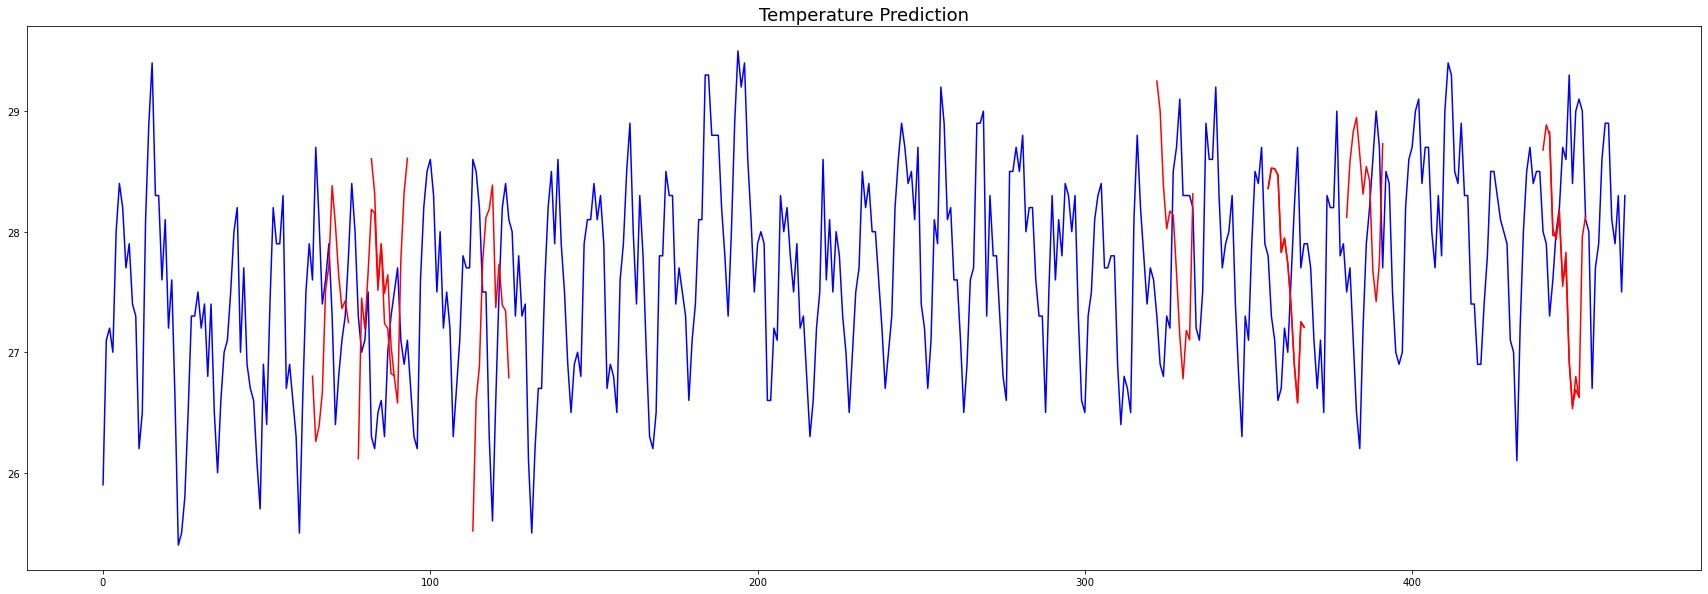

In [28]:
import matplotlib.pyplot as plt

# Data
months = range(0, df.month.size)

# Draw Inline
%matplotlib inline

# Draw Original Lines
plt.figure(figsize = (30,10))
plt.title('Temperature Prediction', fontsize=18)
plt.plot(months, mean_temps, color='b')

# Draw all predicted points
for idx_i, i in enumerate(points):
    i_months = range(i, i+N)
    i_temps = preds[idx_i]
    plt.plot(i_months, i_temps, color='r')
    print("Predicted months: ", i_months)
